## import packages

In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
)
from ripple_heterogeneity.replay import replay_run, leave_one_out_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
import random
from matplotlib.ticker import AutoMinorLocator
import copy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## plotting defaults

In [2]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## load replay data

In [3]:
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7'
replay_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622'

replay_df = replay_run.load_results(replay_save_path,pre_task_post=False)

## run main analysis

In [4]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\leave_one_out_replay_v1"
)
batch_analysis.run(
    replay_df,
    save_path,
    leave_one_out_replay.run,
    parallel=True,
    verbose=True,
    replay_save_path=replay_save_path,
)

results_df = batch_analysis.load_results(save_path,verbose=False)

100%|██████████| 95/95 [00:04<00:00, 19.80it/s] 


## flip scores so higher is better

In [12]:
results_df.left_out_score = results_df.left_out_score*-1
results_df.left_out_score_cell_count_norm = results_df.left_out_score_cell_count_norm*-1


## added sublayer and animal id

In [5]:
results_df = functions.add_animal_id(results_df)

# fix unknown deep sups
results_df.deepSuperficial = results_df.deepSuperficial.replace(np.nan, "unknown")

# add n replays
for basepath in results_df.basepath.unique():
    results_df.loc[results_df.basepath == basepath, "n_replays"] = results_df.query(
        "basepath==@basepath"
    ).start.nunique()

results_df

,left_out_score,left_out_score_cell_count_norm,replay_n,UID,deepSuperficialDistance,deepSuperficial,brainRegion,start,stop,duration,...,traj_speed,traj_step,replay_type,epochs,environment,epoch_n,direction,basepath,animal_id,n_replays
0,0.001360,0.019042,0,9,-28.457275,middle,CA1so,309.81245,309.89245,0.08,...,1570.75,31.415,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,7.0
1,-0.000052,-0.000726,0,10,121.542725,Superficial,CA1sr,309.81245,309.89245,0.08,...,1570.75,31.415,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,7.0
2,-0.034583,-0.484162,0,12,-28.457275,middle,CA1so,309.81245,309.89245,0.08,...,1570.75,31.415,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,7.0
3,0.146957,2.057392,0,15,71.542725,Superficial,CA1sr,309.81245,309.89245,0.08,...,1570.75,31.415,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,7.0
4,-0.000107,-0.001495,0,17,21.542725,middle,CA1sp,309.81245,309.89245,0.08,...,1570.75,31.415,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343961,-0.002206,-0.083846,447,132,15.568191,middle,CA1sp,27394.40285,27394.48285,0.08,...,3360.00,67.200,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,818.0
343962,-0.001907,-0.072458,447,133,15.568191,middle,CA1sp,27394.40285,27394.48285,0.08,...,3360.00,67.200,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,818.0
343963,-0.000101,-0.003840,447,134,-65.502914,Deep,CA1so,27394.40285,27394.48285,0.08,...,3360.00,67.200,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,818.0
343964,-0.002074,-0.078799,447,135,-19.431809,middle,CA1so,27394.40285,27394.48285,0.08,...,3360.00,67.200,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,818.0


In [6]:
results_df["session_structure"] = "unknown"
for basepath in results_df.basepath.unique():
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df, epoch_name="sleep")
    epoch_df = epoch_df.reset_index()
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )

    if pattern_idx is None:
        continue

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[0]),
        "session_structure",
    ] = "pre"
    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[1]),
        "session_structure",
    ] = "task"

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[2]),
        "session_structure",
    ] = "post"

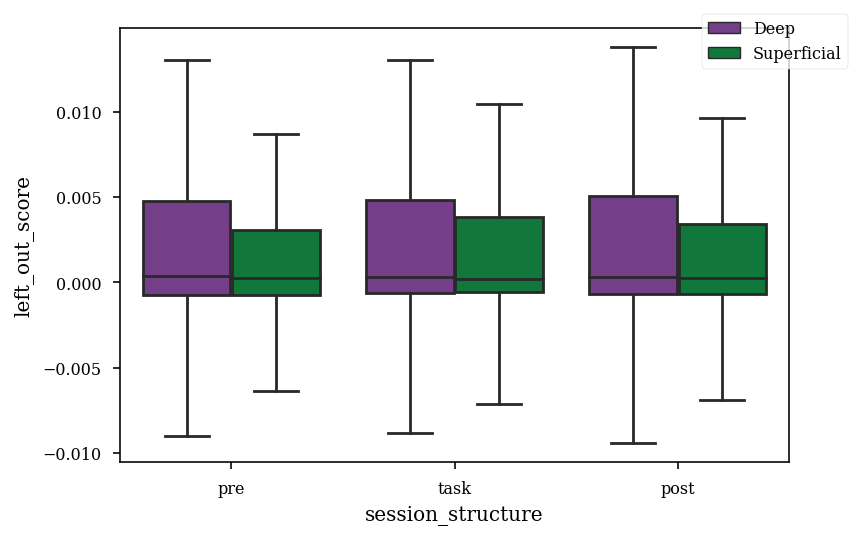

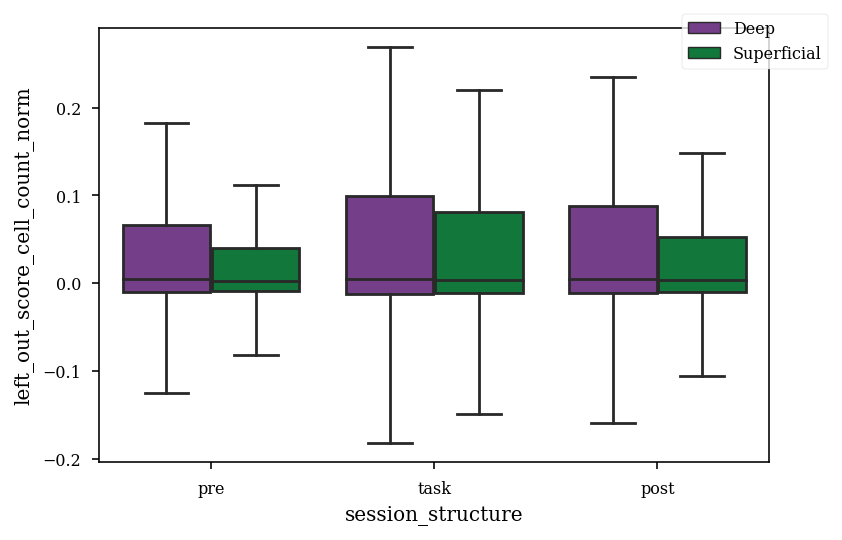

In [13]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
    y="left_out_score",
    x="session_structure",
    order=["pre","task","post"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
    y="left_out_score_cell_count_norm",
    x="session_structure",
    order=["pre","task","post"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

In [24]:
results_df

,left_out_score,left_out_score_cell_count_norm,replay_n,UID,deepSuperficialDistance,deepSuperficial,brainRegion,start,stop,duration,...,replay_type,epochs,environment,epoch_n,direction,basepath,animal_id,per_cell_contribution,n_replays,session_structure
0,0.001360,0.019042,0,9,-28.457275,middle,CA1so,309.81245,309.89245,0.08,...,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,-0.019042,7.0,unknown
1,-0.000052,-0.000726,0,10,121.542725,Superficial,CA1sr,309.81245,309.89245,0.08,...,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,0.000726,7.0,unknown
2,-0.034583,-0.484162,0,12,-28.457275,middle,CA1so,309.81245,309.89245,0.08,...,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,0.484162,7.0,unknown
3,0.146957,2.057392,0,15,71.542725,Superficial,CA1sr,309.81245,309.89245,0.08,...,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,-2.057392,7.0,unknown
4,-0.000107,-0.001495,0,17,21.542725,middle,CA1sp,309.81245,309.89245,0.08,...,reverse,pre,sleep,0.0,outbound_epochs,Z:\Data\AYAold\AB1\day1,AB1,0.001495,7.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343961,-0.002206,-0.083846,447,132,15.568191,middle,CA1sp,27394.40285,27394.48285,0.08,...,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,0.083846,818.0,unknown
343962,-0.001907,-0.072458,447,133,15.568191,middle,CA1sp,27394.40285,27394.48285,0.08,...,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,0.072458,818.0,unknown
343963,-0.000101,-0.003840,447,134,-65.502914,Deep,CA1so,27394.40285,27394.48285,0.08,...,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,0.003840,818.0,unknown
343964,-0.002074,-0.078799,447,135,-19.431809,middle,CA1so,27394.40285,27394.48285,0.08,...,reverse,postSleep2_221215_180815,sleep,6.0,outbound_epochs,Z:\Data\OMLproject\OML27\day3,OML27,0.078799,818.0,unknown


In [28]:
results_df.keys()

Index(['left_out_score', 'left_out_score_cell_count_norm', 'replay_n', 'UID',
       'deepSuperficialDistance', 'deepSuperficial', 'brainRegion', 'start',
       'stop', 'duration', 'n_active', 'inactive_bin_prop', 'trajectory_score',
       'r_squared', 'slope', 'intercept', 'score_pval_time_swap',
       'score_pval_col_cycle', 'traj_dist', 'traj_speed', 'traj_step',
       'replay_type', 'epochs', 'environment', 'epoch_n', 'direction',
       'basepath', 'animal_id', 'per_cell_contribution', 'n_replays',
       'session_structure'],
      dtype='object')

## calculate median per cell across replays

In [18]:
results_df_pivot = pd.pivot_table(
    results_df.query("session_structure != 'unknown' & not left_out_score.isnull() & not left_out_score_cell_count_norm.isnull()"),
    values=["left_out_score","left_out_score_cell_count_norm"],
    index=["basepath", "UID", "deepSuperficial", "n_replays", "animal_id"],
    columns=["session_structure"],
    aggfunc=np.median,
).reset_index()
results_df_pivot.columns = [' '.join(col).strip() for col in results_df_pivot.columns.values]
results_df_pivot

,basepath,UID,deepSuperficial,n_replays,animal_id,left_out_score post,left_out_score pre,left_out_score task,left_out_score_cell_count_norm post,left_out_score_cell_count_norm pre,left_out_score_cell_count_norm task
0,Z:\Data\AYAold\AYA4\day150804,1,middle,2.0,AYA4,NaN,0.076080,NaN,NaN,0.380399,NaN
1,Z:\Data\AYAold\AYA4\day150804,7,Deep,2.0,AYA4,NaN,0.031862,NaN,NaN,0.159312,NaN
2,Z:\Data\AYAold\AYA4\day150804,12,middle,2.0,AYA4,NaN,-0.001386,NaN,NaN,-0.006929,NaN
3,Z:\Data\AYAold\AYA4\day150804,13,Superficial,2.0,AYA4,NaN,0.390480,NaN,NaN,1.952400,NaN
4,Z:\Data\AYAold\AYA4\day150804,20,Superficial,2.0,AYA4,NaN,0.079454,NaN,NaN,0.397272,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2134,Z:\Data\OMLproject\OML27\day3,132,middle,818.0,OML27,0.000651,0.001621,0.005934,0.019855,0.044358,0.255398
2135,Z:\Data\OMLproject\OML27\day3,133,middle,818.0,OML27,0.001231,0.001004,0.001868,0.041502,0.022815,0.066844
2136,Z:\Data\OMLproject\OML27\day3,134,Deep,818.0,OML27,0.000023,0.000040,0.000039,0.000857,0.001004,0.001372
2137,Z:\Data\OMLproject\OML27\day3,135,middle,818.0,OML27,0.001750,0.000408,0.002061,0.058663,0.011657,0.072319


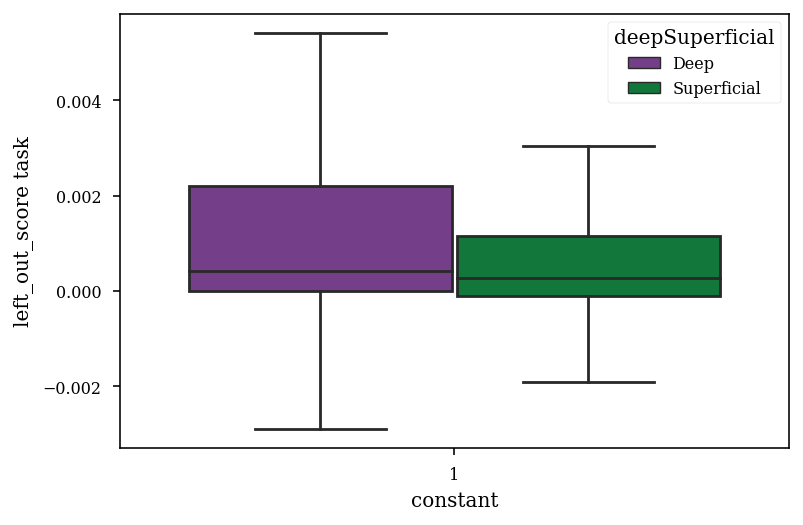

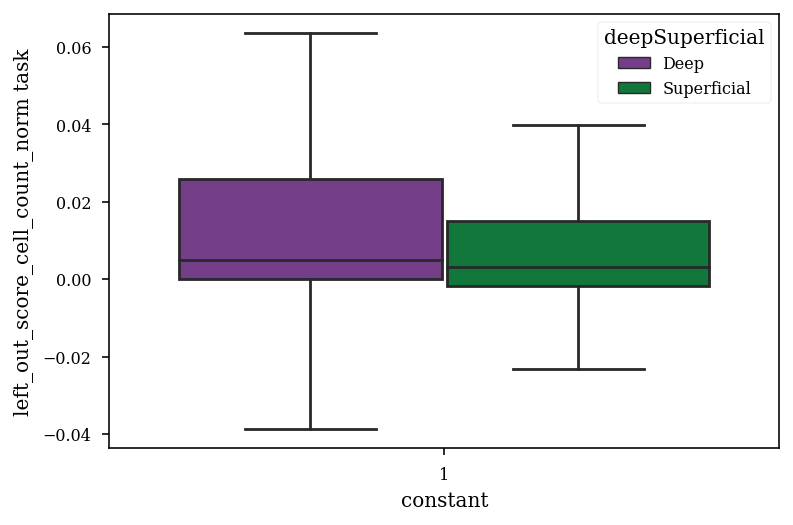

In [23]:
results_df_pivot["constant"] = 1

sns.boxplot(
    data=results_df_pivot,
    y="left_out_score task",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()

sns.boxplot(
    data=results_df_pivot,
    y="left_out_score_cell_count_norm task",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()


## flip avg_left_out_score_cell_count_norm to make per cell contribution

In [ ]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))


keep_idx = (results_df.n_replay > 40) & (results_df.deepSuperficial != "middle")

sns.boxplot(x="deepSuperficial", y="per_cell_contribution",hue_order=group_colors.keys(),
            data=results_df[keep_idx],showfliers=False)

# sns.stripplot(x="deepSuperficial", y="per_cell_contribution",hue_order=group_colors.keys(),
#             data=results_df[keep_idx],color="k",s=2,alpha=0.5)
            
plt.ylabel("per cell contribution")
# plt.ylim(0.001,2)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# plt.gca().invert_yaxis()
# plt.yscale("log")
ax.set_xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "per_cell_contribution.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

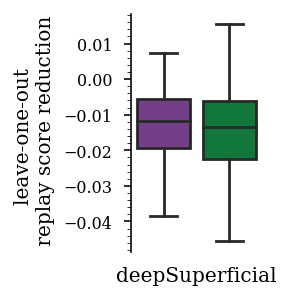

In [19]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))


keep_idx = (results_df.n_replay > 40) & (results_df.deepSuperficial != "middle")

sns.boxplot(x="deepSuperficial", y="avg_left_out_score",hue_order=group_colors.keys(),
            data=results_df[keep_idx],showfliers=False)

# sns.stripplot(x="deepSuperficial", y="avg_left_out_score",hue_order=group_colors.keys(),
#             data=results_df[keep_idx],color="k",s=2)
plt.ylabel("leave-one-out \n replay score reduction")

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)

In [10]:
results_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_score_reduction.csv")
